In [4]:
!pip install torch torchvision torchaudio matplotlib numpy tqdm

In [5]:
# base
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm

# helpers
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.transforms import v2

In [3]:
plt.style.use('dark_background')

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cpu
Epoch: 50


In [5]:
class MNISTDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        
        self.len_dataset = 0
        self.data_list = []
        
        for path_dir, dir_list, file_list in os.walk(path): # os.walk is GENERATOR func
            # print(f'[WALK]: {path_dir} | {dir_list} | {len(file_list)}')
            
            if path_dir == path:
                self.classes = sorted(os.listdir(path_dir))
                self.class_to_index = { cls_name: i for i, cls_name in enumerate(self.classes) }
                continue
            
            cls = path_dir.split(os.sep)[-1]

            for file_name in file_list:
                file_path = os.path.join(path_dir, file_name)
                self.data_list.append((file_path, self.class_to_index[cls]))
                
            self.len_dataset += len(file_list)

    def __len__(self):
        return self.len_dataset
    
    def __getitem__(self, index):
        file_path, target = self.data_list[index]
        sample = Image.open(file_path)
        
        # print(f'[PIL => Sample]: {sample}')
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        return sample, target

In [6]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.5, ), std=(0.5, ))
])

In [ ]:
train_dataset = MNISTDataset(path='./mnist/training', transform=transform)
test_dataset = MNISTDataset(path='./mnist/testing', transform=transform)

In [7]:
train_dataset_split, val_dataset = random_split(train_dataset, [0.7, 0.3])
print(f'[Train]: {len(train_dataset_split)}')
print(f'[Validation]: { len(val_dataset)}')
print(f'[Test]: {len(test_dataset)}')

[Train]: 42000
[Validation]: 18000
[Test]: 10000


In [8]:
train_loader = DataLoader(train_dataset_split, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [24]:
class MyModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layer_1 = nn.Linear(input_size, 128)
        self.layer_2 = nn.Linear(128, output_size)
        self.act = nn.ReLU()
    
    def forward(self, x):
        x = self.layer_1(x)
        x = self.act(x)
        out = self.layer_2(x)
        
        return out

model = MyModel(input_size=784, output_size=10).to(device)

In [25]:
# input = torch.rand([16, 784], dtype=torch.float32).to(device)
# 
# out = model(input)
# out.shape

In [26]:
loss_model = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [3]:
EPOCHS = 50

train_loss = []
train_acc = []
val_loss = []
val_acc = []

In [2]:


for epoch in range(EPOCHS):

    # INFO model training
    model.train()
    train_loop = tqdm(train_loader, leave=False)
    
    running_train_loss = []
    true_answer_counter = 0
    for x, targets in train_loop:
        # print(f'Number of correct answers: {true_answer_counter}')
        
        # (batch_size, 1, 28, 28) -> (batch_size, 784) |784|size by 1 axis -> input AI
        x = x.reshape(-1, 28*28).to(device)
        
        # (batch_size, int) -> (batch_size, 10), dtype=float32
        targets = targets.reshape(-1).to(torch.int32)
        targets = torch.eye(10)[targets].to(device)
        
        prediction = model(x) # forward method
        loss = loss_model(prediction, targets) # loss func
        
        # back prapagetion start
        opt.zero_grad() # reset previously calculated gradients
        loss.backward()
        # back prapagetion end
        
        # optimization step
        opt.step()
        
        # INFO training process visualization
        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss)/len(running_train_loss)
        
        true_answer_counter += (prediction.argmax(dim=1) == targets.argmax(dim=1)).sum().item()
        
        train_loop.set_description(f'Epoch [{epoch+1}/{EPOCHS}], train_loss_avg: {mean_train_loss:.4f}')

    running_train_acc = true_answer_counter/len(train_dataset_split)
    
    train_loss.append(mean_train_loss)
    train_acc.append(running_train_acc)
    
    # INFO model validation
    model.eval()
    with torch.no_grad():
        running_val_loss = []
        true_answer_counter = 0
        for x, targets in val_loader:
            # (batch_size, 1, 28, 28) -> (batch_size, 784) |784|size by 1 axis -> input AI
            x = x.reshape(-1, 28*28).to(device)
            
            # (batch_size, int) -> (batch_size, 10), dtype=float32
            targets = targets.reshape(-1).to(torch.int32)
            targets = torch.eye(10)[targets].to(device)
            
            prediction = model(x)
            loss = loss_model(prediction, targets)
            
            # INFO training process visualization
            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss)/len(running_val_loss)
            
            true_answer_counter += (prediction.argmax(dim=1) == targets.argmax(dim=1)).sum().item()
    
        running_val_acc = true_answer_counter / len(val_dataset)
        
        val_loss.append(mean_val_loss)
        val_acc.append(running_val_acc)
        
        print(f'Epoch [{epoch+1}/{EPOCHS}], train_loss: {mean_train_loss:.4f}, train_metric_acc: {running_train_acc:.4f}, val_loss: {mean_val_loss:.4f}, val_metric_acc: {running_val_acc:.4f}')

NameError: name 'model' is not defined

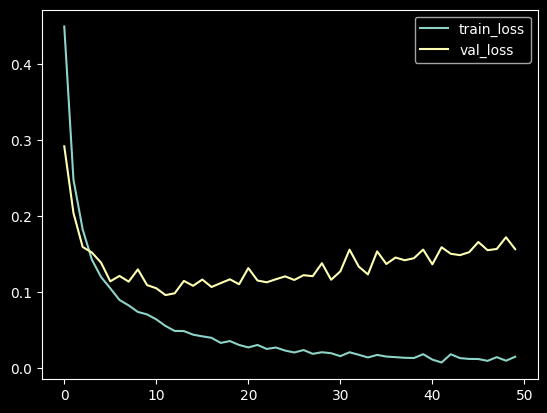

In [28]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train_loss', 'val_loss'])
plt.show()

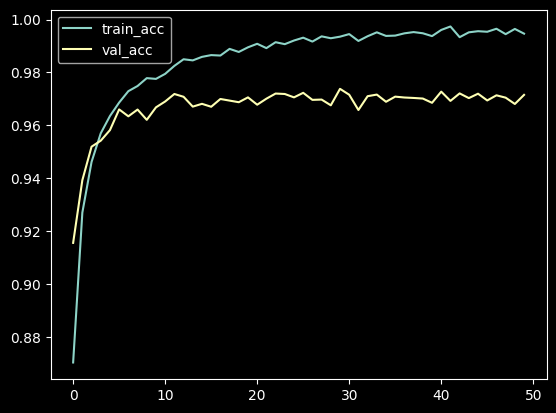

In [29]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['train_acc', 'val_acc'])
plt.show()